# ENSO_pattern: zonal structure of boreal winter SST anomalies in the equatorial Pacific

Computes the zonal root mean square error (RMSE) of boreal winter (December) sea surface temperature anomalies (SSTA) along the equatorial Pacific (150°E–90°W), averaged meridionally over 5°S–5°N. Observations and model outputs are compared after processing, including smoothing with a 5-month triangular-weighted moving average.

## Datasets Used for SSTA Comparison
The following reference datasets are employed to evaluate the ENSO-related SST patterns in model simulations:

- **TropFlux** (1979–2018): The primary dataset for comparison, providing high-quality estimates of surface fluxes and anomalies designed for tropical ocean and climate studies, combining in-situ measurements with satellite-derived data.
Additional datasets include:

- **20CRv2** (1871–2012): A century-scale reanalysis leveraging surface pressure observations to reconstruct global atmospheric conditions.- **ERA-Interim** (1979–2018): A widely used reanalysis dataset offering high-resolution estimates of atmospheric and surface variables with robust data assimilation techniques.
- **ERSSTv5** (1854–2018): A globally gridded dataset of historical SSTs derived from in-situ measurements and optimised for climate monitoring and ENSO studies.
- **HadISST** (1870–2018): A long-term SST and sea ice dataset combining ship and buoy observations with historical data reconstruction.
- **NCEP2** (1979–2018): The second-generation reanalysis dataset from NCEP, improving upon the earlier version for global atmospheric and oceanic variability analysis.

In [1]:
from esmvalcore.dataset import Dataset

In [2]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="18500101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
),
## Note: It is possible to use tos (sea_surface_temperature; degC; ocean; mon) 
# "ACCESS-ESM1-5": 
#     Dataset(
#     short_name='tos',
#     project='CMIP6',
#     mip="Omon",
#     exp="historical",
#     ensemble="r1i1p1f1",
#     timerange="18500101/20190101",
#     dataset="ACCESS-ESM1-5",
#     grid="gn"
# )
}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='ts',
    dataset='HadISST',
    mip="Amon",
    project='OBS',
    type='reanaly',
    tier=2),
# "ERSSTv5":
#     Dataset(
#     short_name='tos',
#     dataset='NOAA-ERSSTv5',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     tier=2),
# "ERA-Interim": 
#     Dataset(
#     short_name='tos',
#     dataset='ERA-Interim',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

## Add Ancillary files

In [3]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [4]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/fx/sftlf/gn/v20191115/sftlf_fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc)


In [5]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
# from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import mask_landsea
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats


In [6]:
## pattern enso, eq
def sst_enso(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land") #shp or land fraction
    cube = extract_region(cube, **nino34_latext_region)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = area_statistics(cube,operator='mean')
    cube = extract_month(cube,12) # get DEC
    #remove time mean
    cube = anomalies(cube,period='monthly')
    return cube

def sst_eq(cube):
    region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **region)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = extract_month(cube,12) # get DEC
    # remove time mean
    cube = anomalies(cube, period='monthly')
    cube = meridional_statistics(cube, 'mean')

    return cube

def lin_regress(cube_ssta, cube_nino34):  # 1d
    # Get the number of longitudes
    nlon = len(cube_ssta.coord('longitude').points)
    
    # Reshape the data to 2D arrays where each row represents a time slice
    nino34_data = cube_nino34.data.flatten()
    ssta_data = np.array([lon_slice.data.flatten() for lon_slice in cube_ssta.slices(['time'])]).T
    
    # Compute the linear regression using matrix operations
    slopes = np.array([scipy.stats.linregress(nino34_data, ssta_data[:, i])[0] for i in range(nlon)])
    
    return cube_ssta.coord('longitude').points, slopes
    

# rmse = np.sqrt(np.mean((obs_regressed - model_regressed) ** 2))

In [7]:
def sst_eq2(cube):
    region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = convert_units(cube, units="degC")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **region)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = extract_month(cube,12) # get DEC
    cube = anomalies(cube, period='monthly')
    return cube
    
def lin_regress_2(cube_ssta, cube_nino34):  # cube_ssta(no meridional_statistics)
    # Flatten the NINO34 data and reshape the SSTA data
    nino34_data = cube_nino34.data.flatten()
    ssta_data = np.array([lonlat_slice.data.flatten() for lonlat_slice in cube_ssta.slices(['time'])]).T
    
    # Perform linear regression for all longitude-latitude points using vectorized operations
    slopes = np.array([scipy.stats.linregress(nino34_data, ssta_data[:, i])[0] for i in range(ssta_data.shape[1])])
    
    # Reshape the slopes array to match the SSTA shape (excluding the time dimension)
    ssta_reg = slopes.reshape(cube_ssta.shape[1], cube_ssta.shape[2])
    
    # Create a new cube with the regression result
    cube = iris.cube.Cube(ssta_reg, long_name='regression ENSO SSTA',
                          dim_coords_and_dims=[(cube_ssta.coord('latitude'), 0),
                                               (cube_ssta.coord('longitude'), 1)])

    return cube

In [8]:
model_datasets_prep1 = {name: sst_enso(dataset) for name, dataset in model_datasets.items()}
model_datasets_prep2 = {name: sst_eq(dataset) for name, dataset in model_datasets.items()}
model_datasets_prep3 = {name: sst_eq2(dataset) for name, dataset in model_datasets.items()}

obs_datasets_prep1 = {name: sst_enso(dataset) for name, dataset in obs_datasets.items()}
obs_datasets_prep2 = {name: sst_eq(dataset) for name, dataset in obs_datasets.items()}
obs_datasets_prep3 = {name: sst_eq2(dataset) for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning:

# Diagnostic Level 1

The first level shows the diagnostic used to compute the metric and highlight the main differences between the model and the reference.

Text(0.5, 0.95, 'RMSE: 0.22 ')

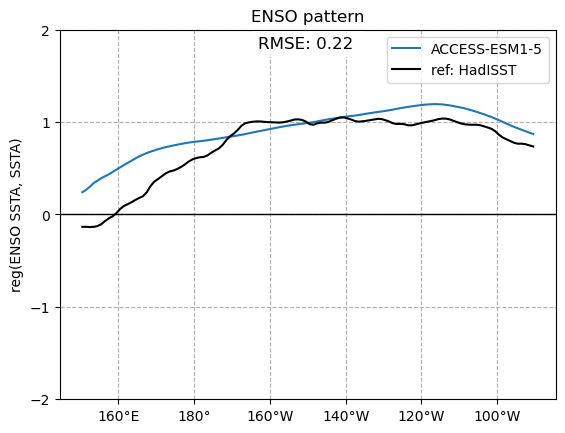

In [9]:
## linear regression sst_eq on sst_enso

def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'


reg_mod = lin_regress(model_datasets_prep2["ACCESS-ESM1-5"], model_datasets_prep1["ACCESS-ESM1-5"])

# return slope data to longitude - array?
plt.plot(reg_mod[0], reg_mod[1], label="ACCESS-ESM1-5") #units

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

reg = lin_regress(obs_datasets_prep2["HadISST"], obs_datasets_prep1["HadISST"])
plt.plot(reg[0],reg[1], color='black',label='ref: HadISST')

plt.yticks(np.arange(-2,3, step=1))
plt.axhline(y=0, color='black', linewidth=1)
plt.ylabel("reg(ENSO SSTA, SSTA)")
plt.title('ENSO pattern') #
plt.legend()
plt.grid(linestyle='--')

rmse = np.sqrt(np.mean((np.array(reg[1]) - np.array(reg_mod[1])) ** 2)) #metric

plt.text(0.5, 0.95, f"RMSE: {rmse:.2f} ", fontsize=12, ha='center', transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

**Figure 1**: Zonal structure of sea surface temperature anomalies (SSTA) in the equatorial Pacific (averaged between 5°S and 5°N). The figure highlights the zonal distribution of SSTA associated with ENSO, which is typically overestimated west of the dateline; in this case, the anomalies are too strong in the central Pacific. The black curve represents the reference data, while the blue curve corresponds to the model output. The derived metric is the zonal root mean square error (RMSE) between the model and reference curves.

## Diagnostic Level 2

The second level shows the broader picture to better understand the spatial pattern of ENSO: the map of the anomalies in the equatorial Pacific.


In [10]:
reg2_mod = lin_regress_2(model_datasets_prep3["ACCESS-ESM1-5"], model_datasets_prep1["ACCESS-ESM1-5"])
reg2_obs = lin_regress_2(obs_datasets_prep3["HadISST"], obs_datasets_prep1["HadISST"])
#make dict process
process = {"ACCESS-ESM1-5":reg2_mod , "HadISST":reg2_obs} 

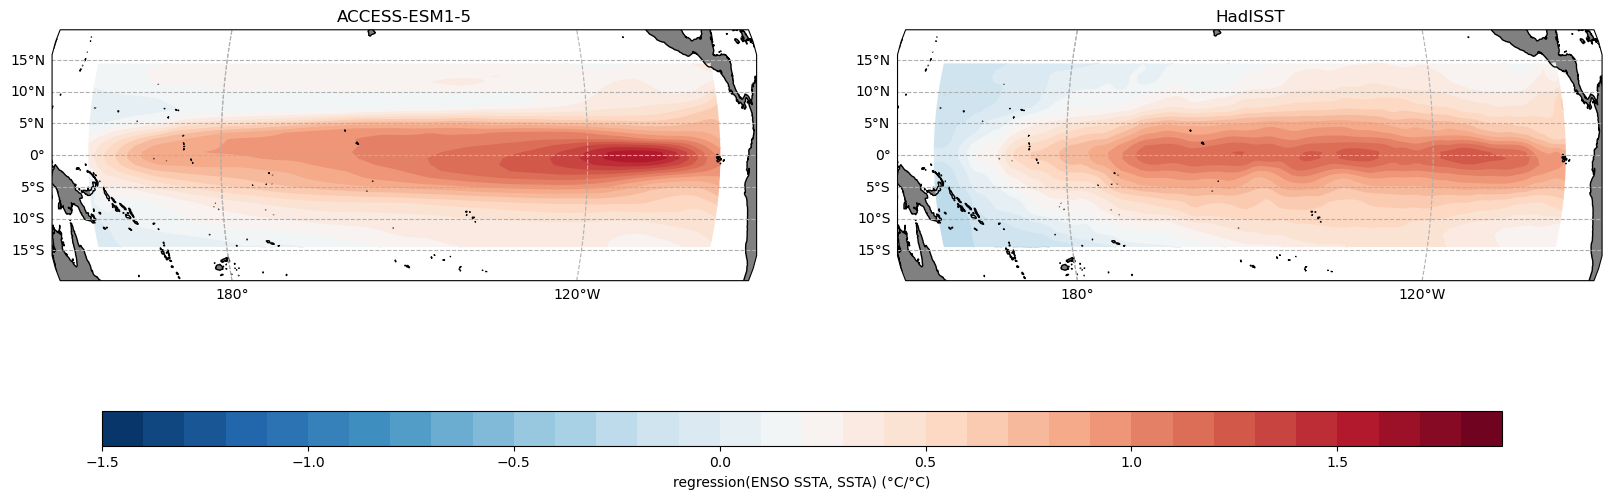

In [11]:
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 7))
proj = ccrs.Orthographic(central_longitude=210.0)
i =121
# process = {**model_datasets_prep3, **obs_datasets_prep3}


for label, cube in process.items():
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(-1.5,2,0.1), cmap='RdBu_r')
    # cf1 = plt.contourf(reg2[0],reg2[1],reg2[2], cmap='RdBu_r', levels=np.arange(0,2,0.1))

    ax1.set_extent([130, 290, -20, 20], crs=ccrs.PlateCarree())
    ax1.set_title(label)

    # Add gridlines for latitude and longitude
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False

    i+=1


# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-2,2.5,0.5))
cbar.set_label('regression(ENSO SSTA, SSTA) (°C/°C)')

Figure 2: sea surface temperature anomalies (SSTA) associated with ENSO in the equatorial Pacific, showing usually the SSTA too far west (here too strong in the central Pacific). The left and right maps show respectively the reference and the model.